# Tuesday Afternoon: Inference after Pooling

In [1]:
import numpy as np
import pandas as pd
import scipy as sp
import numpy_indexed as npi
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression

np.random.seed(1)

# Part 1: Simulating "Running" an MRT with Pooling RL

## Simple Data Generating Environment
- "Covariates": $O_t = (1, B_t, C_t, D_t)$ where $B_t$ is binary and $C_t$ is continuous and $D_t$ is a measure of "dosage"
    - Specifically $D_t = \frac{1}{1-\gamma} \sum_{t'=1}^{t-1} \gamma^{t'} A_{t'}$ for $\gamma = 0.95$. We normalize by $1-\gamma$ to ensure $D_t \in [0,1]$.
- Binary action $A_t \in \{0, 1\}$
- Rewards are generated as follows:

$$
R_{t+1} = f_0(O_t)^\top \alpha_0 + A_t f_1(O_t)^\top \alpha_1 + \epsilon_t
$$

where $f_0(O_t) = (1, B_t, C_t, D_t)$, $f_1(O_t) = (1, C_t)$, 


$\alpha_0 = (1, -0.8, 0.05, -0.7)$, $\alpha_1 = (0.3, 0)$, $\epsilon_t \sim \mathcal{N}(0,\sigma_{\mathrm{env}}^2)$.

In [2]:
env_params = {
    "alpha0": np.array([1, 0.5, 0.2, -0.7]),
    "alpha1": np.array([0.3, 0.05]),
    "sigma_env": 0.5,
    "B_p": 0.3,
}

def generate_reward(state, action, env_params):
    base_state = np.array([1, state[1], state[2], state[3]])
    treat_state = np.array([1, state[2]])
    
    base_mean_reward = np.dot( base_state, env_params["alpha0"] )
    mean_reward = base_mean_reward + \
                    action * np.dot( treat_state, env_params["alpha1"] )
    reward = mean_reward + np.random.normal(scale=env_params["sigma_env"])
    return reward
        

def generate_state(prev_state, prev_action, prev_reward, env_params):
    B = np.random.binomial(1, env_params["B_p"])
    C = np.random.normal(3, scale=1)
    
    # Form dosage update
    gamma = 0.95
    norm_gamma = 1/(1-gamma)
    if prev_state is None:
        dosage = np.random.binomial(1, 0.5)
    else:
        dosage = (gamma*norm_gamma*prev_state[-1] + prev_action ) / norm_gamma
    
    state = np.array([1, B, C, dosage])
    return state

## Pooling Boltzmann Sampler

- Boltzmann or Softmax sampling algorithm
- RL algorithm's model of the reward:

$$
\mathbb{E} [ R_{i,t+1} | H_{i,t-1}, S_{i,t}, A_{i,t} ]= \phi_0(S_t)^\top \beta_0 + A_{i,t} \phi_1(S_{i,t})^\top \beta_1
$$

where $\phi_0(S_{i,t}) = (1, C_{i,t})$, $\phi_1(S_{i,t}) = (1, C_{i,t})$.

- Fitting the $\hat{\beta}_{t-1}$ using all past user data:
$$
\hat{\beta}_{t-1} = \big[ \hat{\beta}_{t-1,0}, \hat{\beta}_{t-1,1} \big] = \mathrm{argmin}_{\beta} \sum_{i=1}^n \sum_{t'=1}^{t-1} \left( R_{i,t'+1} - \phi_0(S_{t'})^\top \beta_0 - A_{i,t'} \phi_1(S_{i,t'})^\top \beta_1 \right)^2
$$

- Form action selection probabilities
$$
\mathbb{P}(A_{i,t} = 1 | H_{1:n,t}, S_{i,t}) = \pi_\min + (1-2\pi_\min) * \left[ 1 + \exp \left( - b_{\mathrm{steep}} \phi_1(S_{i,t})^\top \hat{\beta}_{t-1,1} \right) \right]^{-1}
$$
Generalized logistic function with $b_{\mathrm{steep}}$ as hyperparameter.
Also, $\pi_\min$ constrains action selection probabilities so for $\pi_{\min} = 0.1$

$$
\mathbb{P}(A_{i,t} = 1 | H_{1:n,t}, S_{i,t}) \in [\pi_{\min}, 1 - \pi_{\min}] ~~~~ \mathrm{with~probability}~1
$$

### Pooling Boltzmann Sampler: Algorithm Statistics

__Estimating Equation Formulation:__ $\hat{\beta}_t$ solves $0 = \frac{1}{n} \sum_{i=1}^n \dot{g}_{i,t}(\hat{\beta}_t)$
where 
$$\dot{g}_{i,t}(\beta_t) \triangleq \sum_{t'=1}^t \left( R_{i,t'+1} - \phi_0(S_{t'})^\top \beta_0 - A_{i,t'} \phi_1(S_{i,t'})^\top \beta_1 \right) \begin{bmatrix} \phi_0(S_{t'}) \\ A_{i,t'} \phi_1(S_{i,t'}) \end{bmatrix}$$

__Hessian:__
$$\ddot{G}_t \triangleq - \sum_{t'=1}^t \begin{bmatrix} \phi_0(S_{t'}) \\ A_{i,t'} \phi_1(S_{i,t'}) \end{bmatrix}^{\otimes 2}$$

In [3]:
class PoolingBoltzmanSampler:
    
    def __init__(self, n, pi_min, b_steep=1):
        self.pi_min = pi_min
        self.b_steep = b_steep
        
        self.all_policies = [ {
            "policy_num": 0,
            "R_vec": None,
            "feat_matrix": None,
            "beta_est": None,
            "user_ids": None,
        } ]
        self.all_decisions = {}
      
    
    def form_action1_prob(self, beta_est, treat_feats):
        lin_est = np.dot(beta_est[-2:], treat_feats)
        prob = self.pi_min + (1-2*self.pi_min) / ((1 + np.exp(-self.b_steep * lin_est)))
        
        return prob
    
    
    def select_action(self, state, user_id):
    
        # Posterior Mean and Variance for beta_1 (treatment effect)
        treat_feats = np.array([state[0], state[2]]).T
        beta_est = self.all_policies[-1]['beta_est']
        
        if beta_est is None:
            action1_prob = 0.5
            pi_grad = None
        else:
            action1_prob = self.form_action1_prob(beta_est, treat_feats)
            epsilon = np.sqrt(np.finfo(float).eps)
            pi_grad = sp.optimize.approx_fprime(beta_est, 
                                            self.form_action1_prob, 
                                            epsilon,
                                            treat_feats)
            
        action = np.random.binomial(1, action1_prob)
            
        policy_num = self.all_policies[-1]['policy_num']
        if policy_num in self.all_decisions.keys():
            self.all_decisions[policy_num]["all_user_ids"].append( user_id )
            self.all_decisions[policy_num]["all_treat_feats"].append( treat_feats )
            self.all_decisions[policy_num]["all_action1_probs"].append( action1_prob )
            self.all_decisions[policy_num]["all_actions"].append( action )
            self.all_decisions[policy_num]["all_pi_grad"].append( pi_grad )
        else:
            self.all_decisions[policy_num] = { 
                "policy_num": policy_num,
                "beta_est": beta_est,
                "all_user_ids": [user_id],
                "all_treat_feats": [treat_feats],
                "all_action1_probs": [action1_prob],
                "all_pi_grad": [pi_grad],
                "all_actions": [action],
            }
    
        return action, action1_prob
    

    def update_algorithm(self, new_states, new_actions, new_rewards, new_user_ids):
        alg_info = self.all_policies[-1]
        
        prev_R_vec = alg_info['R_vec']
        prev_feat_matrix = alg_info['feat_matrix']
        prev_user_ids = alg_info['user_ids']
        
        feat_matrix = np.array([new_states[:,0], new_states[:,2], 
                           new_actions, new_actions*new_states[:,2]]).T
        rewards = np.expand_dims(new_rewards, 1)
        
        if prev_R_vec is None:
            new_R_vec = rewards
        else:
            new_R_vec = np.concatenate([prev_R_vec.copy(), rewards], axis=0)
            
        if prev_feat_matrix is None:
            new_feat_matrix = feat_matrix
        else:
            new_feat_matrix = np.concatenate([prev_feat_matrix.copy(), feat_matrix], axis = 0)
            
        if prev_user_ids is None:
            all_user_ids = new_user_ids
        else:
            all_user_ids = np.concatenate([prev_user_ids.copy(), new_user_ids], axis = 0)
        
        RX = np.sum(new_feat_matrix*new_R_vec, 0)
        XX = np.einsum( 'ij,ik->jk', new_feat_matrix, new_feat_matrix )
        inv_XX = np.linalg.inv( XX )
        beta_est = np.matmul(inv_XX, RX.reshape(-1))
        
        # ALGORITHM STATISTICS -----------------------------------------
        
        # Forming estimating equations for beta_est
        residuals = new_R_vec.squeeze() - np.matmul(new_feat_matrix, beta_est)
        residuals = np.expand_dims(residuals, 1)
        raw_est_eqns = residuals * new_feat_matrix
        _, est_eqns = npi.group_by(all_user_ids).sum(raw_est_eqns)
        
        # Forming hessian for beta_est
        alg_hessian = - np.einsum('ij,ik->jk', new_feat_matrix, new_feat_matrix) / n
            
        new_alg_info = {
                        "policy_num": alg_info['policy_num']+1,
                        "R_vec": new_R_vec,
                        "feat_matrix": new_feat_matrix,
                        "beta_est": beta_est,
                        "est_eqns": est_eqns,
                        "user_ids": all_user_ids,
                        "hessian": alg_hessian,
                        }
        self.all_policies.append(new_alg_info)

### Preparing the MRT Dataframe

In [4]:
def make_empty_study_df(T, n):
    dataset_rownames = ["user_id", "decision_t", "reward", 
                        "action", "action1_prob", "intercept", "binary", "continuous", "dosage"]

    # Fill in user_ids and decision times
    user_id_all = np.repeat([i for i in range(1,n+1)], T)
    decision_t_all = np.tile([i for i in range(1,T+1)], n)
    empty_cols = np.empty((n*T, len(dataset_rownames)-2))
    empty_cols[:] = np.nan

    # Make dataframe to record study data
    dataset_entries = np.hstack( [ np.stack([user_id_all, decision_t_all]).T, empty_cols ] )
    study_df = pd.DataFrame(dataset_entries, columns=dataset_rownames)

    # Change type of columns
    type_dict = {
        'user_id': int,
        'decision_t': int,
    }
    study_df = study_df.astype(type_dict)
    
    return study_df

### Simulating the MRT

In [5]:
def simulate_MRT(T, n, env_params, RL_alg):
    study_df = make_empty_study_df(T, n)
    
    # Loop over decision times
    for t in range(1,T+1):
    
        # Loop over users in the study
        all_states = []
        all_actions = []
        all_action1_probs = []
        all_rewards = []
        for user_id in range(1,n+1):
        
            # Generate state
            if t == 1:
                state = generate_state(None, None, None, env_params)
            else:
                state = generate_state(prev_states[user_id-1], 
                                    prev_actions[user_id-1], 
                                    prev_rewards[user_id-1], env_params)
        
            # Form action selection probabilities
            action, action1_prob = RL_alg.select_action(state, user_id)
            
        
            # Generate reward
            reward = generate_reward(state, action, env_params)
        
            # Record data
            all_states.append(state)
            all_actions.append(action)
            all_action1_probs.append(action1_prob)
            all_rewards.append(reward)
    
        # Save all user data
        all_states = np.array(all_states)
        all_actions = np.array(all_actions)
        all_action1_probs = np.array(all_action1_probs)
        all_rewards = np.array(all_rewards)
        
        # Update Algorithm
        RL_alg.update_algorithm(new_states = all_states, 
                     new_actions = all_actions, 
                     new_rewards = all_rewards, 
                     new_user_ids = np.arange(1,n+1))
    
        idx_t = study_df.index[study_df['decision_t'] == t]
        half_row_data = np.vstack([all_rewards, all_actions, all_action1_probs]).T
        row_data = np.hstack([half_row_data, all_states])      
        study_df.iloc[idx_t,2:] = row_data
        
        # Prepare for next decision time
        prev_states = all_states
        prev_actions = all_actions
        prev_rewards = all_rewards
    

    type_dict = {
        'action': int,
        'intercept': int,
        'binary': int,
    }
    study_df = study_df.astype(type_dict)
    return study_df

In [6]:
T = 50
n = 100
pi_min = 0.1
b_steep = 1

# Form Decision Making Policy and Run MRT Study
RL_alg = PoolingBoltzmanSampler(n=n, pi_min=pi_min, b_steep=b_steep)
study_df = simulate_MRT(T, n, env_params, RL_alg)

# Print first 10 rows of dataframe
print("Average Treatment Prob: {}".format(np.mean(study_df['action1_prob'])))
print("")
study_df.head(10)

Average Treatment Prob: 0.5832820660809711



,user_id,decision_t,reward,action,action1_prob,intercept,binary,continuous,dosage
0,1,1,1.215127,0,0.500000,1,0,2.197827,0.000000
1,1,2,2.936776,1,0.544893,1,1,4.377510,0.000000
2,1,3,1.499297,0,0.563411,1,0,2.832585,0.050000
3,1,4,1.872682,1,0.555602,1,0,2.994290,0.047500
4,1,5,2.152184,1,0.567990,1,0,4.139551,0.095125
5,1,6,1.432369,1,0.572140,1,0,2.941154,0.140369
6,1,7,1.805764,1,0.570170,1,0,2.093228,0.183350
7,1,8,0.844827,0,0.594030,1,0,4.489415,0.224183
8,1,9,2.564130,1,0.576619,1,1,2.209942,0.212974
9,1,10,2.971348,1,0.581493,1,0,3.550368,0.252325


# Part 2: Analyze Pooling RL MRT Data

## Estimating Causal Excursion Effect 
$$
\theta^\star = \mathbb{E}_{\pi^\star} \left[ Y_{t+1}( \bar A_{t-1}, 1 ) - Y_{t+1}( \bar A_{t-1}, 0 ) \right]
$$

$$
\hat{\theta} = \mathrm{argmin_{(\theta_0, \theta_1) \in \mathbb{R}^2}} \left\{ \frac{1}{n} \sum_{i=1}^n \sum_{t=1}^T \left( Y_{i,t+1} - \psi(H_{i,t-1}, O_{i,t})^\top \theta_0 - A_{i,t} \theta_1 \right)^2 \right\}
$$
where $\psi(H_{i,t-1}, O_{i,t}) = [1, C_{i,t}]$

In [7]:
def form_feat_matrix(study_df, base_feat_names, treat_feat_names):
    base_feats = np.vstack([study_df[feat] for feat in base_feat_names]).T
    treat_feats = np.vstack([study_df[feat] for feat in treat_feat_names]).T
    actions = actions = study_df['action']

    actions = np.expand_dims(actions, 1)
    feat_matrix = np.concatenate([ base_feats, actions*treat_feats], axis=1)
        
    return feat_matrix

In [8]:
# Form Least Squares Estimator
Y_vec = study_df['reward'].to_numpy()
all_user_ids = study_df['user_id'].to_numpy()
feat_matrix = form_feat_matrix(study_df, 
                               base_feat_names = ["intercept", "continuous"],
                               treat_feat_names = ["intercept"])

# Fit Linear Model
reg = LinearRegression().fit(feat_matrix, Y_vec)
thetahat = reg.coef_.copy()
thetahat[0] = reg.intercept_

print("Estimated excursion effect (theta_1):")
print( thetahat[-1:] )

Estimated excursion effect (theta_1):
[0.45426671]


## Estimating Variance via Standard Sandwich Variance

### Standard Sandwich Variance Estimator: $\big( \ddot{L}^{(n)} \big)^{-1} \Sigma^{(n)} \big( \ddot{L}^{(n)} \big)^{-1, \top}$

- $\ddot{L}^{(n)}$ is an estimate of the Hessian or "bread" part of the sandwich variance:
$$
\ddot{L}^{(n)} \triangleq - \frac{1}{n} \sum_{i=1}^n \sum_{t=1}^T \begin{bmatrix} \psi(H_{i,t-1}, O_{i,t}) \\ A_{i,t} \end{bmatrix}^{\otimes 2}
$$
(we use the notation $x^{\otimes 2} \triangleq x x^\top$ for any vector $x$)

- $\hat{\Sigma}^{(n)}$ is an estimate of the "meat" part of the sandwich variance:
$$
\hat{\Sigma}^{(n)} \triangleq \frac{1}{n} \sum_{i=1}^n \dot{\ell}_i(\hat\theta)^{\otimes 2}
$$
where $\dot{\ell}_i(\theta) \triangleq \sum_{t=1}^T \left( Y_{i,t+1} - \psi(H_{i,t-1}, O_{i,t})^\top \theta_0 - A_{i,t} \theta_1 \right) \begin{bmatrix} \psi(H_{i,t-1}, O_{i,t}) \\ A_{i,t} \end{bmatrix}$

Above, we use $\psi(H_{i,t-1}, O_{i,t}) = [1, C_{i,t}]$.

In [9]:
def least_squares_est_eqns(feat_matrix, thetahat, Y_vec, all_user_ids):
    residuals = Y_vec - np.matmul(feat_matrix, thetahat)
    residuals = np.expand_dims(residuals, 1)
    raw_est_eqns = residuals * feat_matrix
    est_eqns = npi.group_by(all_user_ids).sum(raw_est_eqns)
    return est_eqns


def least_squares_hessian(feat_matrix):
    hessian = -np.einsum('ij,ik->ijk', feat_matrix, feat_matrix).mean(0)
    return hessian

In [10]:
def get_sandwich_variance(est_eqns, hessian, thetahat):
    meat = np.einsum( 'ij,ik->jk', est_eqns, est_eqns )
    meat = meat / n

    inv_hessian = np.linalg.inv( hessian )
    sandwich_var = np.matmul( np.matmul(inv_hessian, meat), inv_hessian )
    sandwich_var = sandwich_var / n
    return sandwich_var

In [11]:
_, theta_est_eqns = least_squares_est_eqns(feat_matrix, thetahat, Y_vec, all_user_ids)
theta_hessian = least_squares_hessian(feat_matrix)
sandwich_var = get_sandwich_variance(theta_est_eqns, theta_hessian, thetahat)

print("Estimated sandwich variance for theta_1:")
print( sandwich_var[-1][-1] )

Estimated sandwich variance for theta_1:
0.775056610915535


## Estimating Variance via Adaptive Sandwich Variance

### Adaptive Sandwich Variance Estimator: $\big( \ddot{L}^{(n)} \big)^{-1} \Sigma_{\mathrm{adapt}}^{(n)} \big( \ddot{L}^{(n)} \big)^{-1, \top}$

Note that $\big( \ddot{L}^{(n)} \big)^{-1} \Sigma_{\mathrm{adapt}}^{(n)} \big( \ddot{L}^{(n)} \big)^{-1, \top}$ is equivalent to the bottom right block of the matrix 
$$\begin{bmatrix} \ddot{G}_{1:T-1}^{(n)} & 0 \\
V_{1:T-1}^{(n)} & \ddot{L}^{(n)} \end{bmatrix}^{-1} \Sigma_{1:T}^{(n)} \begin{bmatrix} \ddot{G}_{1:T-1}^{(n)} & 0 \\
V_{1:T-1}^{(n)} & \ddot{L}^{(n)} \end{bmatrix}^{-1, \top}$$
where
$\Sigma_{1:T}^{(n)}$ is an estimate of the "stacked meat" part of the adaptive sandwich variance:
$$
\Sigma_{1:T}^{(n)} \triangleq \frac{1}{n} \sum_{i=1}^n \begin{pmatrix} \dot{g}_{i,1}(\hat\beta_1) \\
\dot{g}_{i,2}(\hat\beta_2) \\
\vdots \\
\dot{g}_{i,T-1}(\hat\beta_{T-1}) \\
\dot{\ell}_i(\hat{\theta}) \end{pmatrix}^{\otimes 2}
$$
where $\dot{\ell}_i(\theta) \triangleq \sum_{t=1}^T \left( Y_{i,t+1} - \psi(H_{i,t-1}, O_{i,t})^\top \theta_0 - A_{i,t} \theta_1 \right) \begin{bmatrix} \psi(H_{i,t-1}, O_{i,t}) \\ A_{i,t} \end{bmatrix}$ and
$\dot{g}_{i,t}(\beta_t) \triangleq \sum_{t'=1}^t \left( R_{i,t'+1} - \phi_0(S_{t'})^\top \beta_0 - A_{i,t'} \phi_1(S_{i,t'})^\top \beta_1 \right) \begin{bmatrix} \phi_0(S_{t'}) \\ A_{i,t'} \phi_1(S_{i,t'}) \end{bmatrix}$

(we use the notation $x^{\otimes 2} \triangleq x x^\top$ for any vector $x$)

In [12]:
def get_stacked_est_eqns(RL_alg, theta_est_eqns):

    all_est_eqns = []
    for policy_dict in RL_alg.all_policies:
        policy_num = policy_dict['policy_num']
        if policy_num in [0, T]:
            continue
        tmp_est_eqns = RL_alg.all_policies[1]['est_eqns']
        all_est_eqns.append(tmp_est_eqns)

    all_est_eqns.append(theta_est_eqns)
    stacked_est_eqns = np.concatenate(all_est_eqns, axis=1)
    
    return stacked_est_eqns


def get_weight_derivates(RL_alg):
    all_W_grads = {}
    
    for policy_num in RL_alg.all_decisions.keys():
        if policy_num == 0:
            continue

        tmp_pi_grad = np.array(RL_alg.all_decisions[policy_num]['all_pi_grad'])
        tmp_actions = np.array(RL_alg.all_decisions[policy_num]['all_actions'])
        tmp_action1_probs = np.array(RL_alg.all_decisions[policy_num]['all_action1_probs'])

        tmp_actions = np.expand_dims(tmp_actions, 1)
        tmp_action1_probs = np.expand_dims(tmp_action1_probs, 1)

        W_grads = tmp_pi_grad * tmp_actions / tmp_action1_probs \
                    - tmp_pi_grad * (1-tmp_actions) / (1-tmp_action1_probs)
    
        all_W_grads[policy_num] = W_grads
    
    return all_W_grads

def get_stacked_hessian(RL_alg, theta_est_eqns, theta_hessian):
    # Collect Hessians (Block Diagonal)
    alg_hessian = []
    for policy_dict in RL_alg.all_policies:
        policy_num = policy_dict['policy_num']
        if policy_num in [0, T]:
            continue
        hessian = RL_alg.all_policies[policy_num]['hessian']
        alg_hessian.append(hessian)

    # Get Estimating Equations
    stacked_est_eqns = get_stacked_est_eqns(RL_alg, theta_est_eqns)

    # Outer produt of W grads and estimating equations
    all_W_grads = get_weight_derivates(RL_alg)
    all_columns = []
    for policy_num in all_W_grads.keys():
        col = np.einsum('ij,ik->jk', stacked_est_eqns, all_W_grads[policy_num]) / n
        all_columns.append( col )

    # Form Stacked hessian
    beta_dim = alg_hessian[0].shape[0]
    theta_dim = theta_hessian.shape[0]

    stacked_hessian_col = []
    for policy_dict in RL_alg.all_policies:
        policy_num = policy_dict['policy_num']
        if policy_num in [0, T]:
            continue
        zeros = np.zeros(((policy_num-1)*beta_dim, beta_dim))
        tmp_hessian = alg_hessian[policy_num-1]
        tmp_col = np.concatenate([ zeros, tmp_hessian, all_columns[policy_num-1][policy_num*beta_dim:] ], axis=0 )
        stacked_hessian_col.append( tmp_col )
    
    zeros = np.zeros(((T-1)*beta_dim, theta_dim))
    last_col = np.concatenate([zeros, theta_hessian])
    stacked_hessian_col.append(last_col)
    stacked_hessian = np.hstack(stacked_hessian_col)
    
    return stacked_hessian

def get_adaptive_sandwich_variance(stacked_est_eqns, stacked_hessian):
    inv_stacked_hessian = np.linalg.inv( stacked_hessian )
    stacked_meat = np.einsum('ij,ik->jk', stacked_est_eqns, stacked_est_eqns) / n
    stacked_sandwich = np.matmul( np.matmul(inv_stacked_hessian, stacked_meat), inv_stacked_hessian.T ) / n
    return stacked_sandwich

In [13]:
# Get Estimating Equations
stacked_est_eqns = get_stacked_est_eqns(RL_alg, theta_est_eqns)
stacked_hessian = get_stacked_hessian(RL_alg, theta_est_eqns, theta_hessian)

stacked_sandwich = get_adaptive_sandwich_variance(stacked_est_eqns, stacked_hessian)

print("Estimated adaptive sandwich variance for theta_1:")
print( stacked_sandwich[-1,-1] )

Estimated adaptive sandwich variance for theta_1:
0.7928601489728864


## Exercises

(1) Compare Standard Sandwich and Adaptive Sandwich Variance Estimators

(2) Examine the `b_steep` argument Boltzmann sampling hyperparameter
    $$\mathbb{P}(A_{i,t} = 1 | H_{1:n,t}, S_{i,t}) = \pi_\min + (1-2\pi_\min) * \left[ 1 + \exp \left( - b_{\mathrm{steep}} \phi_1(S_{i,t})^\top \hat{\beta}_{t-1,1} \right) \right]^{-1}$$
    
   (2a) How does changing $b_{\mathrm{steep}} > 0$ change the action selection probabilities? Can make a plot.
    
   (2b) How does changing `b_steep` affect the sandwich and adaptive sandwich variance estimators? For example, compare `b_steep = 5` vs `b_steep = 1`
    
(3) Examine the Posterior Sampling and epsilon-greedy algorithms you looked at earlier in Raaz's coding session. Show that these algorithms do not converge to a limiting policy when the treatment effect (or margin) is zero. Compare this to using a Botlzmann sampling algorithm


__Optional / Additional Exercises:__
- Use the sandwich and adaptive sandwich variances to form 95% confidence intervals for $\theta_1^\star$
- How does changing the data generating environment affect the sandwich and adaptive sandwich variance estimators?
- How does changing the model used to form $\theta$ affect the sandwich and adaptive sandwich variance estimators? Can look at excursion effects conditioned on state.
- Compare to the individual RL algorithm to personalize, as used in the Monday afternoon exercise

# Solutions

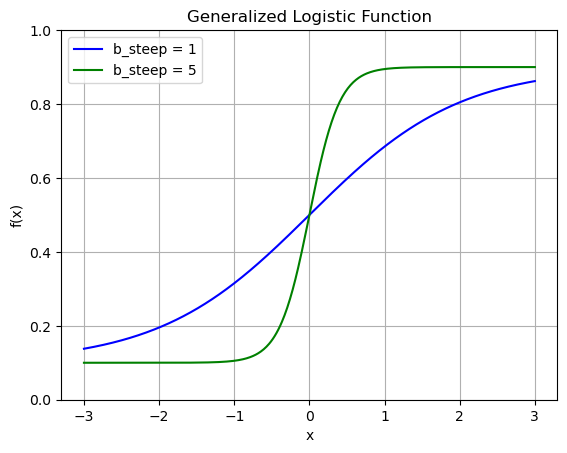

In [14]:
def logistic_function(x, pi_min, b_steep):
    return pi_min + (1-2*pi_min) / ((1 + np.exp(-b_steep * x)))

# Generate x values
x = np.linspace(-3, 3, 500)

# Compute y values using the generalized logistic function
y1 = logistic_function(x, pi_min, b_steep=1)
y5 = logistic_function(x, pi_min, b_steep=5)

# Plot the generalized logistic function
plt.plot(x, y1, label='b_steep = 1', color='blue')
plt.plot(x, y5, label='b_steep = 5', color='green')
plt.xlabel('x')
plt.ylabel('f(x)')
plt.ylim(0,1)
plt.title('Generalized Logistic Function')
plt.legend()
plt.grid(True)
plt.show()

In [15]:
T = 50
n = 100
pi_min = 0.1
b_steep = 5

# Form Decision Making Policy and Run MRT Study
RL_alg = PoolingBoltzmanSampler(n=n, pi_min=pi_min, b_steep=b_steep)
study_df = simulate_MRT(T, n, env_params, RL_alg)

# Print first 10 rows of dataframe
print("Average Treatment Prob: {}".format(np.mean(study_df['action1_prob'])))
print("")
study_df.head(10)

Average Treatment Prob: 0.8224387619673583



,user_id,decision_t,reward,action,action1_prob,intercept,binary,continuous,dosage
0,1,1,2.041791,1,0.500000,1,0,3.191668,1.000000
1,1,2,1.524209,0,0.804439,1,0,3.232629,1.000000
2,1,3,1.510612,1,0.757659,1,1,2.659192,0.950000
3,1,4,0.145476,1,0.838512,1,0,3.087327,0.952500
4,1,5,1.583447,1,0.837272,1,1,1.342691,0.954875
5,1,6,1.616093,1,0.829726,1,0,1.507763,0.957131
6,1,7,2.190345,1,0.853908,1,1,3.597751,0.959275
7,1,8,1.028869,1,0.846364,1,0,3.034398,0.961311
8,1,9,1.276377,1,0.840096,1,0,2.871314,0.963245
9,1,10,1.399894,1,0.831721,1,0,2.474531,0.965083


In [16]:
_, theta_est_eqns = least_squares_est_eqns(feat_matrix, thetahat, Y_vec, all_user_ids)
theta_hessian = least_squares_hessian(feat_matrix)
sandwich_var = get_sandwich_variance(theta_est_eqns, theta_hessian, thetahat)

print("Estimated sandwich variance for theta_1:")
print( sandwich_var[-1][-1] )

Estimated sandwich variance for theta_1:
0.775056610915535


In [17]:
# Get Estimating Equations
stacked_est_eqns = get_stacked_est_eqns(RL_alg, theta_est_eqns)
stacked_hessian = get_stacked_hessian(RL_alg, theta_est_eqns, theta_hessian)

stacked_sandwich = get_adaptive_sandwich_variance(stacked_est_eqns, stacked_hessian)

print("Estimated adaptive sandwich variance for theta_1:")
print( stacked_sandwich[-1,-1] )

Estimated adaptive sandwich variance for theta_1:
0.8771407842455797


## For additional solutions, see the slides "Kelly - Tuesday Afternoon - Inference after Pooling Practical"